
### $\textbf{1. Introduction \& Setup}$



<font size = '4'>

 $\textbf{What is Cosmic On Air?}$

<font size = '3'>

 The Cosmic On Air Project studies cosmic radiation exposure during commercial flights usuing portable radiation detectors. As aircraft climb to cruising altitudes (typically 9-12 km), they encounter significantly higher levels of cosmic radiation due to:
- $\textbf{Reduced atmospheric shielding:}$ The atmosphere normally absorbs most cosmic rays
- $\textbf{Altitude effect:}$ Radiation exposure increases exponentially with altitude
- $\textbf{Latitude effect:}$ Higher radiation levels near the poles due to Earth's magnetic field geometry



<font size = '4'>

$\textbf{Physics Background}$

<font size = 3>

Cosmic rays are high-energy particles (primarily protons) from outer space that interact with Earth's atomosphere, creating secondary particles including neutrons, muons, and gamma rays. The radiation dose is measured in:
- $\textbf{Counts Per Minute (CPM):}$ Raw detector measurements
- $\textbf{microSieverts per hour (μSv/h):}$ Biological dose rate (CPM ÷ 334 for typical detectors)

<font size = '4'>

$\textbf{This Notebook's Workflow}$

<font size = 3>

1. $\textit{Visulize raw data}$ - Plot radiation vs time ot identify flight phases
2. $\textit{Process GPS data}$ - Combine detector GPS with FlightAware data for complete coverage
3. $\textit{Analyze spatial patterns}$ - Study radiation vs altitude, latitude and longitude
4. $\textit{Compare with models}$ - validate measurements against CARI-7 predictions
5. $\textit{Generate reports}$ - Create publication-ready visualizations

In [24]:
# Import all required libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import numpy as np
import csv
from pathlib import Path
import cartopy.crs as ccrs
from pykml import parser
from datetime import timedelta

# Set plotting style for better readability
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

### $\textbf{2. Configuration}$


<font size = 3>

$\textbf{Important:}$ Update these paths to match your data files before running the notebook.

In [26]:
# =============================================================================
# CONFIGURATION SECTION - UPDATE THESE PATHS FOR YOUR DATA
# =============================================================================

# File paths (update these for your specific data)
RAW_DATA_FILE = 'C:\\Users\\Tadeck\\.CodingBrav\\Cosmic On Air\\Example Data Sets\\Cape Town to Amsterdam ( Flight KLM598 - 12_06_2024)\\Raw Data\\Raw_data_ 32890612.log'
FLIGHTAWARE_KML = 'C:\\Users\\Tadeck\\.CodingBrav\\Cosmic On Air\\Example Data Sets\\Cape Town to Amsterdam ( Flight KLM598 - 12_06_2024)\\FlightAware\\FlightAware_KLM598_FACT_EHAM_20240612.kml'
OUTPUT_DIR = 'C:\\Users\\Tadeck\\.CodingBrav\\Cosmic On Air\\Example Data Sets\\Cape Town to Amsterdam ( Flight KLM598 - 12_06_2024)\\Analysis_Output\\'

# Flight information (update for your flight)
FLIGHT_INFO = {
    'route': 'Cape Town to Amsterdam',
    'date': '12/06/2024',
    'flight_number': 'KLM598',
    'detector_id': '3289'
}

# Analysis parameters
CONVERSION_FACTOR = 334  # CPM to μSv/h conversion
GPS_AVAILABLE = False    # Set to True if GPS data is accurate in raw file
TIME_LIMITS = (1300, 9200)  # Indices to exclude pre-takeoff/post-landing data
ALTITUDE_THRESHOLD = 1.0     # km - minimum altitude for cruise analysis

# Create output directory if it doesn't exist
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print("Configuration loaded successfully!")
print(f"Flight: {FLIGHT_INFO['route']} ({FLIGHT_INFO['date']})")
print(f"Detector: {FLIGHT_INFO['detector_id']}")

Configuration loaded successfully!
Flight: Cape Town to Amsterdam (12/06/2024)
Detector: 3289


### Webscraping Flight Data

<font size = 3>
 
 The code below webscrapes the flight data (GPS coordinates and date/time) from the flight tracking log page. Use this if you don't have access to the FlightAware KML files for you flight. It still needs to be integrated into the notebook for effeicient use but you're more than welcome to fiddle around with it

In [ ]:
# Import required libraries
from bs4 import BeautifulSoup            # For parsing HTML content
from selenium import webdriver           # For automating browser actions
import time                              # For adding delays to allow content to load
from datetime import datetime, timedelta  # For date/time processing


In [72]:
# (Requires: pip install webdriver-manager)

# Install the appropriate WebDriver for your browser version:
# - Chrome: chromedriver
# - Firefox: geckodriver
# - Edge: msedgedriver
# - Safari: safaridriver


# Launch a new instance of the browser using Selenium WebDriver
driver = webdriver.Chrome()   # replace with your browser's WebDriver, e.g., webdriver.Chrome()

# Navigate to the specific FlightAware flight tracking log page
driver.get("https://www.flightaware.com/live/flight/KQA706/history/20250618/0810Z/FLKK/FVRG/tracklog")

# Retrieve the full HTML content of the page after it loads
html = driver.page_source

# Wait for 5 seconds to ensure JavaScript-rendered elements are fully loaded
time.sleep(5)

# Parse the HTML content using BeautifulSoup with the 'lxml' parser for efficiency
soup = BeautifulSoup(html, 'lxml')

# Optional debug line: prints prettified HTML output
# print(soup.prettify())

# Close the browser now that the content has been fetched
driver.quit()

# Find all <tr> tags with class 'smallrow1' or 'smallrow2'
# These rows contain the actual telemetry data from the flight log
table_data_tags = soup.find_all('tr', class_=['smallrow1', 'smallrow2'])

# Initialize an empty list to hold all extracted flight data
all_data = []

# Loop through each <tr> tag to extract flight data
for tr_tag in table_data_tags:

    # Get list of classes associated with the tag
    tr_classes = tr_tag.get('class', [])

    # Skip this row if it has more than one class (usually decorative or irrelevant rows)
    if len(tr_classes) > 1:
        continue

    # Get all <span> tags that hold the relevant telemetry text data
    # Exclude the last one as it's not useful
    span_tags = tr_tag.find_all('span', class_='show-for-medium-up')[:-1]

    # Extract and clean the text from each <span> tag
    row_data = []
    for flight_data in span_tags:
        text = flight_data.get_text().strip()
        row_data.append(text if text else '')  # Store empty string if no text present

    # Add the current row's data to the full list
    all_data.extend(row_data)

# Initialize empty lists for each telemetry field
datetime_web = []
latitude_web = []
longitude_web = []
altitude_web = []

# The data comes in repeating sets of 4: datetime, latitude, longitude, altitude
# This loop separates them into their respective lists
for i in range(0, len(all_data), 4):
    datetime_web.append(all_data[i] if i < len(all_data) else '')
    latitude_web.append(all_data[i+1] if i+1 < len(all_data) else '')
    longitude_web.append(all_data[i+2] if i+2 < len(all_data) else '')
    altitude_web.append(all_data[i+3] if i+3 < len(all_data) else '')   ## This is in feet, not km

# Convert raw time strings (e.g. "Wed 10:45:27PM") to ISO datetime format
#Assume starting date is taken from the URL 2025-06-18
start_date = datetime.strptime("2025-06-18", "%Y-%m-%d")
current_date = start_date
last_hour = None
processed_datetimes = []


for dt_str in datetime_web:
    print("Raw time string:", dt_str)                           # Debug line to show raw time strings
    try:
        # Extract the time part (e.g. "10:45:27PM" or "04:54:52 AM") from the string
        time_part = dt_str.split()[1] + " " + dt_str.split()[2]
        # print("Extracted time:", time_part)                     # Debug line to show extracted time
        time_obj = datetime.strptime(time_part, "%I:%M:%S %p")
        # print(time_obj)

        # Handle day rollover (if time goes backward)
        if last_hour is not None and time_obj.hour < last_hour:
            current_date += timedelta(days=1)

        last_hour = time_obj.hour

        # Combine date and time
        full_dt = datetime.combine(current_date.date(), time_obj.time())
        iso_format = full_dt.isoformat()
        processed_datetimes.append(iso_format)

    except Exception as e:
        processed_datetimes.append("")  # Append empty string if parsing fails

# Replace original date_time with processed ISO datetimes
datetime_web = processed_datetimes

# After processing the datetimes, update all_data with ISO format
for i in range(0, len(all_data), 4):
    if i < len(processed_datetimes):
        all_data[i] = processed_datetimes[i//4]  # Replace original datetime with ISO format

print("Updated first few entries of all_data:")
print(all_data[:8])  # Show first 2 data points (8 elements)



Raw time string: Wed 03:58:27 AM
Raw time string: Wed 03:58:45 AM
Raw time string: Wed 03:59:05 AM
Raw time string: Wed 03:59:25 AM
Raw time string: Wed 03:59:51 AM
Raw time string: Wed 04:00:21 AM
Raw time string: Wed 04:00:51 AM
Raw time string: Wed 04:01:08 AM
Raw time string: Wed 04:01:28 AM
Raw time string: Wed 04:01:53 AM
Raw time string: Wed 04:02:23 AM
Raw time string: Wed 04:02:54 AM
Raw time string: Wed 04:03:24 AM
Raw time string: Wed 04:03:43 AM
Raw time string: Wed 04:04:16 AM
Raw time string: Wed 04:04:46 AM
Raw time string: Wed 04:05:16 AM
Raw time string: Wed 04:05:47 AM
Raw time string: Wed 04:06:17 AM
Raw time string: Wed 04:06:47 AM
Raw time string: Wed 04:07:17 AM
Raw time string: Wed 04:07:47 AM
Raw time string: Wed 04:08:17 AM
Raw time string: Wed 04:08:47 AM
Raw time string: Wed 04:09:18 AM
Raw time string: Wed 04:09:48 AM
Raw time string: Wed 04:10:18 AM
Raw time string: Wed 04:10:48 AM
Raw time string: Wed 04:11:18 AM
Raw time string: Wed 04:11:48 AM
Raw time s

### $\textbf{3. Data Loading \& Processing} $


<font size = 3>

$\textbf{Raw Data Format}$

The Safecast detector generates NMEA-style strings with the format:
$BNRDD,device_id,timestamp,cpm_1min,cpm_5sec,total_counts,validity,lat,lat_dir,lon,lon_dir,alt,gps_valid,hdop,extra


$\textbf{Loading Raw Radiation}$

In [27]:
def load_raw_data(file_path):
    """
    Load and parse raw radiation data from Safecast detector log file.
    
    Args:
        file_path (str): Path to the .log file
        
    Returns:
        tuple: (times, counts, dose_rates) - lists of datetime objects, 
               counts per minute, and dose rates in μSv/h
    """
    times = []
    counts = []
    dose_rates = []
    
    print(f"Loading raw data from: {Path(file_path).name}")
    
    try:
        with open(file_path, 'r') as f:
            for line_num, line in enumerate(f, 1):
                if line.startswith('$BNRDD'):
                    try:
                        parameters = line.split(',')
                        
                        # Extract time and convert to datetime
                        time_str = parameters[2]
                        formatted_time = datetime.datetime.strptime(
                            time_str, '%Y-%m-%dT%H:%M:%SZ'
                        )
                        
                        # Extract radiation measurements
                        count = int(parameters[3])  # counts per minute
                        dose = count / CONVERSION_FACTOR  # convert to μSv/h
                        
                        times.append(formatted_time)
                        counts.append(count)
                        dose_rates.append(dose)
                        
                    except (ValueError, IndexError) as e:
                        print(f"Warning: Error parsing line {line_num}: {e}")
                        continue
                        
    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
        return [], [], []
    
    print(f"Successfully loaded {len(times)} data points")
    print(f"Time range: {times[0]} to {times[-1]}")
    print(f"Max radiation: {max(counts):.1f} CPM ({max(dose_rates):.2f} μSv/h)")
    
    return times, counts, dose_rates

# Load the raw data
times, counts, dose_rates = load_raw_data(RAW_DATA_FILE)

Loading raw data from: Raw_data_ 32890612.log
Successfully loaded 9502 data points
Time range: 2024-06-12 21:13:06 to 2024-06-13 10:28:51
Max radiation: 908.0 CPM (2.72 μSv/h)


$\textbf{Advanced Data Parser for GPS Integration}$

In [28]:
def parse_detailed_log(file_path):
    """
    Parse log file and extract all available parameters including GPS data.
    
    Args:
        file_path (str): Path to the log file
        
    Returns:
        tuple: (data_all, data_gps) - all data and GPS-validated data only
    """
    data_all = []
    
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if not row or row[0].startswith('#'):
                continue
                
            try:
                # Parse each field from the NMEA string
                record = {
                    'device_id': row[1][1:],  # Remove leading character
                    'datetime': datetime.datetime.strptime(row[2], '%Y-%m-%dT%H:%M:%SZ'),
                    'cpm_1min': int(row[3]),
                    'cpm_5sec': int(row[4]),
                    'total_counts': int(row[5]),
                    'count_validity': row[6],
                    'gps_lat': float(row[7][:2]) + float(row[7][2:]) / 60,  # Convert to decimal degrees
                    'gps_lat_dir': row[8],
                    'gps_lon': float(row[9][:3]) + float(row[9][3:]) / 60,  # Convert to decimal degrees
                    'gps_lon_dir': row[10],
                    'gps_alt': float(row[11]),  # meters
                    'gps_validity': row[12],
                    'gps_hdop': float(row[13]),
                    'gps_extra': row[14] if len(row) > 14 else ''
                }
                
                # Apply hemisphere corrections
                if record['gps_lat_dir'] == 'S':
                    record['gps_lat'] *= -1
                if record['gps_lon_dir'] == 'W':
                    record['gps_lon'] *= -1
                    
                data_all.append(record)
                
            except (ValueError, IndexError) as e:
                continue
    
    # Filter for GPS-valid data (where GPS fix is available)
    data_gps = [d for d in data_all if d['gps_validity'] == 'A']
    
    print(f"Parsed {len(data_all)} total records, {len(data_gps)} with valid GPS")
    
    return data_all, data_gps

# Parse detailed data for advanced analysis
if len(times) > 0:  # Only proceed if raw data loaded successfully
    data_all, data_gps = parse_detailed_log(RAW_DATA_FILE)

Parsed 9502 total records, 1378 with valid GPS


### $\textbf{4. Data Quality Control \& Preprocessing}$

<font size = 3>

$\textbf{Removing Security Scanner Artifacts}$

Airport security X-ray machines can cause radiation spikes (~$40\mu Sv/h$) that need to be filtered out before analysis. This section identifies and removes these artifacts to ensure clean flight data

In [29]:
def export_dose_time_data(times, dose_rates, output_dir, flight_info):
    """
    Export time and dose rate data to a text file for quality control inspection.
    
    Args:
        times: List of datetime objects
        dose_rates: List of dose rates in μSv/h
        output_dir: Directory to save the file
        flight_info: Flight information dictionary
        
    Returns:
        str: Path to the exported file
    """
    filename = f"dose_rate_datetime_{flight_info['detector_id']}.txt"
    file_path = Path(output_dir) / filename
    
    with open(file_path, 'w') as f:
        f.write("Time\tDose Rate\n")
        for t, dose_rate in zip(times, dose_rates):
            f.write(f"{t}\t{dose_rate}\n")
    
    print(f"Raw data exported to: {filename}")
    return str(file_path)

def filter_security_artifacts(input_file, output_dir, threshold=15.0):
    """
    Remove high-dose security scanner artifacts from the dataset.
    
    Security X-ray machines typically produce doses of 20-40+ μSv/h, which are
    much higher than typical flight radiation (0.1-8 μSv/h at cruise).
    
    Args:
        input_file: Path to the raw dose rate file
        output_dir: Directory to save filtered file
        threshold: Maximum dose rate to keep (μSv/h)
        
    Returns:
        str: Path to the filtered file
    """
    output_file = Path(output_dir) / f"{Path(input_file).stem}_filtered.txt"
    
    filtered_lines = []
    total_points = 0
    filtered_points = 0
    
    with open(input_file, 'r') as f:
        lines = f.readlines()
        header = lines[0]
        
        for line in lines[1:]:  # Skip header
            parts = line.split('\t')
            if len(parts) >= 2:
                total_points += 1
                try:
                    dose_rate = float(parts[1].strip())
                    if dose_rate <= threshold:
                        filtered_lines.append(line)
                    else:
                        filtered_points += 1
                except ValueError:
                    continue
    
    # Write filtered data
    with open(output_file, 'w') as f:
        f.write(header)
        f.writelines(filtered_lines)
    
    print(f"Quality Control Results:")
    print(f"  Total data points: {total_points:,}")
    print(f"  Points filtered out: {filtered_points:,} ({100*filtered_points/total_points:.1f}%)")
    print(f"  Threshold used: {threshold} μSv/h")
    print(f"  Filtered data saved to: {output_file.name}")
    
    if filtered_points > total_points * 0.1:  # More than 10% filtered
        print("High percentage of data filtered - check threshold value")
    elif filtered_points > 0:
        print("Security artifacts successfully removed")
    else:
        print("No artifacts detected above threshold")
    
    return str(output_file)

def load_filtered_data(file_path):
    """
    Load filtered dose rate and time data from text file.
    
    Args:
        file_path: Path to filtered data file
        
    Returns:
        tuple: (filtered_times, filtered_doses) as datetime objects and floats
    """
    filtered_doses = []
    filtered_times = []
    
    with open(file_path, 'r') as f:
        next(f)  # Skip header
        for line in f:
            columns = line.split('\t')
            if len(columns) >= 2:
                time_str = columns[0].strip()
                dose_rate = float(columns[1].strip())
                
                # Convert time string to datetime object
                time_obj = datetime.datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')
                
                filtered_times.append(time_obj)
                filtered_doses.append(dose_rate)
    
    print(f"Loaded {len(filtered_doses)} filtered data points")
    return filtered_times, filtered_doses

def identify_flight_boundaries(dose_rates, sensitivity=0.1):
    """
    Automatically identify the start and end of flight based on dose rate changes.
    
    This function finds where radiation levels deviate significantly from ground levels,
    indicating takeoff and landing phases.
    
    Args:
        dose_rates: List of dose rates
        sensitivity: Minimum change to detect flight boundaries
        
    Returns:
        tuple: (start_index, end_index) of flight data
    """
    if len(dose_rates) < 10:
        return 0, len(dose_rates) - 1
    
    # Find start of flight (significant increase from baseline)
    start_index = 0
    baseline = dose_rates[0]
    
    for i in range(1, len(dose_rates)):
        if abs(dose_rates[i] - baseline) > sensitivity:
            start_index = i
            break
    
    # Find end of flight (return to low levels)
    end_index = len(dose_rates) - 1
    end_baseline = dose_rates[-1]
    
    for i in range(len(dose_rates) - 2, 0, -1):
        if abs(dose_rates[i] - end_baseline) > sensitivity:
            end_index = i
            break
    
    # Validate boundaries
    if start_index >= end_index:
        print("Warning: Could not identify clear flight boundaries")
        return 0, len(dose_rates) - 1
    
    flight_duration = end_index - start_index
    total_duration = len(dose_rates)
    
    print(f"Flight Boundary Detection:")
    print(f"  Flight start: index {start_index} ({100*start_index/total_duration:.1f}% into dataset)")
    print(f"  Flight end: index {end_index} ({100*end_index/total_duration:.1f}% into dataset)")
    print(f"  Flight data: {flight_duration} points ({100*flight_duration/total_duration:.1f}% of total)")
    
    return start_index, end_index

# Execute quality control pipeline
if len(times) > 0:
    print("### Data Quality Control Pipeline")
    print("Removing security scanner artifacts and identifying flight boundaries...")
    
    # Export raw data
    raw_data_file = export_dose_time_data(times, dose_rates, OUTPUT_DIR, FLIGHT_INFO)
    
    # Filter security artifacts
    filtered_data_file = filter_security_artifacts(raw_data_file, OUTPUT_DIR, threshold=15.0)
    
    # Load cleaned data
    clean_times, clean_doses = load_filtered_data(filtered_data_file)
    
    # Identify flight boundaries
    flight_start, flight_end = identify_flight_boundaries(clean_doses)
    
    # Extract flight-only data
    flight_times = clean_times[flight_start:flight_end]
    flight_doses = clean_doses[flight_start:flight_end]
    
    print(f" Quality control complete - ready for analysis with {len(flight_doses)} clean data points")

### Data Quality Control Pipeline
Removing security scanner artifacts and identifying flight boundaries...
Raw data exported to: dose_rate_datetime_3289.txt
Quality Control Results:
  Total data points: 9,502
  Points filtered out: 0 (0.0%)
  Threshold used: 15.0 μSv/h
  Filtered data saved to: dose_rate_datetime_3289_filtered.txt
No artifacts detected above threshold
Loaded 9502 filtered data points
Flight Boundary Detection:
  Flight start: index 1465 (15.4% into dataset)
  Flight end: index 8979 (94.5% into dataset)
  Flight data: 7514 points (79.1% of total)
 Quality control complete - ready for analysis with 7514 clean data points


### $\textbf{4. Initial Data Visualization}$

<font size = 4>

$\textbf{Understanding Flight Phases}$

<font size = 3>

A typical radiation vs time plot shows distinct phases:
1. $\textbf{Ground/taxi:}$ Low, stable radiation (~20-50 CPM)
2. $\textbf{Takeoff/climb:}$ Rapid increase as altitude increases
3. $\textbf{Cruise:}$ High, relatively stable radiation (200-800 CPM)
4. $\textbf{Descent/landing:}$ Rapid decrease back to ground levels

### Radiation vs Time Analysis
This plot shows how radiation levels change throughout the flight.
Notice the dramatic increase during climb and decrease during descent.


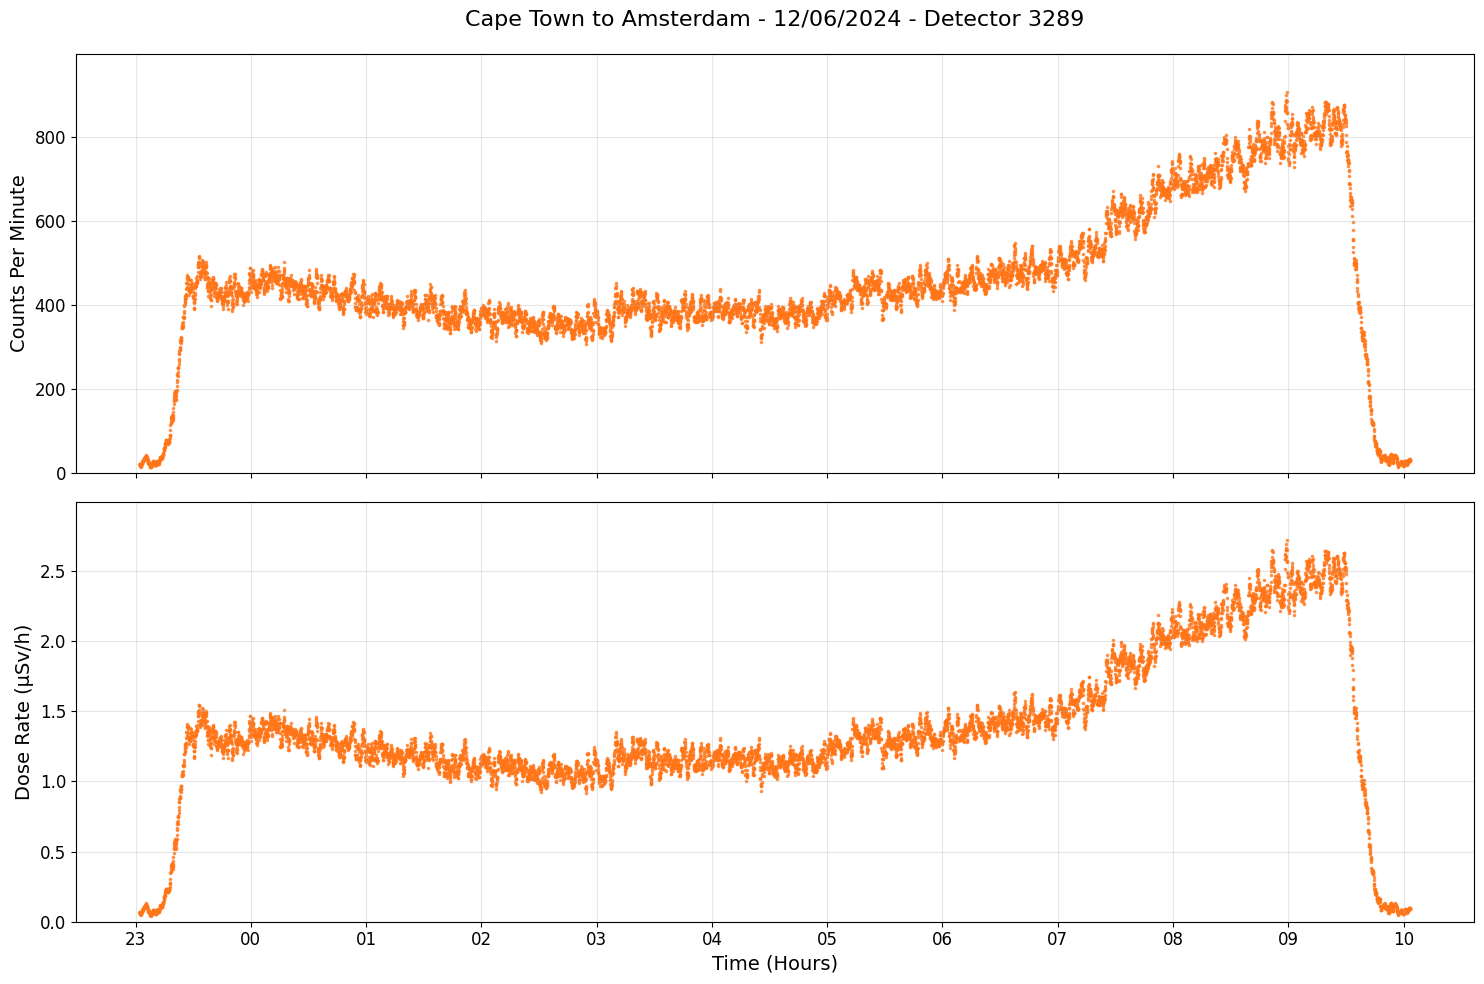

In [30]:
def plot_radiation_vs_time(times, counts, dose_rates, flight_info, time_limits=None):
    """
    Create a comprehensive radiation vs time plot showing flight phases.
    
    Args:
        times: List of datetime objects
        counts: List of counts per minute
        dose_rates: List of dose rates in μSv/h
        flight_info: Dictionary with flight information
        time_limits: Tuple of (start_index, end_index) to focus on flight
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    
    # Apply time limits if specified
    if time_limits:
        start_idx, end_idx = time_limits
        plot_times = times[start_idx:end_idx]
        plot_counts = counts[start_idx:end_idx]
        plot_doses = dose_rates[start_idx:end_idx]
    else:
        plot_times = times
        plot_counts = counts
        plot_doses = dose_rates
    
    # Plot 1: Counts per minute
    ax1.scatter(plot_times, plot_counts, marker='.', color='#FF7518', s=10, alpha=0.7)
    ax1.set_ylabel('Counts Per Minute', fontsize=14)
    ax1.set_ylim(0, max(plot_counts) * 1.1)
    ax1.grid(True, alpha=0.3)
    ax1.set_title(f'{flight_info["route"]} - {flight_info["date"]} - Detector {flight_info["detector_id"]}', 
                  fontsize=16, pad=20)
    
    
    # Plot 2: Dose rate
    ax2.scatter(plot_times, plot_doses, marker='.', color='#FF7518', s=10, alpha=0.7)
    ax2.set_ylabel('Dose Rate (μSv/h)', fontsize=14)
    ax2.set_xlabel('Time (Hours)', fontsize=14)
    ax2.set_ylim(0, max(plot_doses) * 1.1)
    ax2.grid(True, alpha=0.3)
    
    # Format x-axis to show hours
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax2.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}radiation_vs_time.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create the radiation vs time plot
if len(times) > 0:
    print("### Radiation vs Time Analysis")
    print("This plot shows how radiation levels change throughout the flight.")
    print("Notice the dramatic increase during climb and decrease during descent.")
    plot_radiation_vs_time(times, counts, dose_rates, FLIGHT_INFO, TIME_LIMITS)

### $\textbf{5. Advanced Analysis with Flight Path}$

<font size = 4>

$\textbf{FlightAware Data Integration}$

FlightAware provides precise GPS coordinates when the detector's GPS is unavailable or inaccurate. This is crucial for correlating radiation levels with geographic position

In [31]:
def load_flightaware_data(kml_file):
    """
    Parse FlightAware KML file to extract flight path coordinates and times.
    
    Args:
        kml_file (str): Path to FlightAware KML file
        
    Returns:
        tuple: (kml_times, kml_coordinates) - lists of datetime objects and coordinate dicts
    """
    try:
        with open(kml_file, 'r') as f:
            doc = parser.parse(f).getroot()
    except FileNotFoundError:
        print(f"FlightAware file not found: {kml_file}")
        return [], []
    
    # Extract timestamps
    kml_times = []
    for element in doc.Document.Placemark[2].findall(".//{http://www.opengis.net/kml/2.2}when"):
        timestamp = datetime.datetime.strptime(element.text, "%Y-%m-%dT%H:%M:%SZ")
        kml_times.append(timestamp)
    
    # Extract coordinates
    kml_coordinates = []
    for element in doc.Document.Placemark[2].findall(".//{http://www.google.com/kml/ext/2.2}coord"):
        lon, lat, alt = element.text.split(' ')
        kml_coordinates.append({
            'lon': float(lon),
            'lat': float(lat), 
            'alt': float(alt)  # meters
        })
    
    print(f"Loaded FlightAware data: {len(kml_times)} points")
    print(f"Flight duration: {kml_times[-1] - kml_times[0]}")
    
    return kml_times, kml_coordinates

def interpolate_coordinates(kml_values, kml_times, data_times):
    """
    Interpolate FlightAware coordinates to match detector measurement times.
    
    Args:
        kml_values: List of coordinate values to interpolate
        kml_times: FlightAware timestamps
        data_times: Detector measurement timestamps
        
    Returns:
        list: Interpolated values
    """
    interpolated = []
    kml_idx = 0
    
    for data_time in data_times:
        # Handle times before first FlightAware point
        if data_time < kml_times[0]:
            interpolated.append(kml_values[0])
        # Handle times after last FlightAware point  
        elif data_time > kml_times[-1]:
            interpolated.append(kml_values[-1])
        else:
            # Find bracketing points for interpolation
            while kml_idx < len(kml_times) - 1 and kml_times[kml_idx] < data_time:
                kml_idx += 1
            
            if kml_idx == 0:
                interpolated.append(kml_values[0])
            else:
                # Linear interpolation
                t0, t1 = kml_times[kml_idx-1], kml_times[kml_idx]
                v0, v1 = kml_values[kml_idx-1], kml_values[kml_idx]
                
                # Calculate interpolation weight
                weight = (data_time - t0).total_seconds() / (t1 - t0).total_seconds()
                interpolated_value = v0 + weight * (v1 - v0)
                interpolated.append(interpolated_value)
    
    return interpolated

# Load FlightAware data and interpolate coordinates
if len(data_all) > 0:
    kml_times, kml_coords = load_flightaware_data(FLIGHTAWARE_KML)
    
    if kml_times:  # Only proceed if FlightAware data loaded successfully
        
        # Extract coordinate lists for interpolation
        kml_lats = [coord['lat'] for coord in kml_coords]
        kml_lons = [coord['lon'] for coord in kml_coords] 
        kml_alts = [coord['alt'] for coord in kml_coords]
        
        # Get detector measurement times
        data_times = [d['datetime'] for d in data_all]
        
        # Interpolate coordinates
        interp_lats = interpolate_coordinates(kml_lats, kml_times, data_times)
        interp_lons = interpolate_coordinates(kml_lons, kml_times, data_times)
        interp_alts = interpolate_coordinates(kml_alts, kml_times, data_times)
        
        print(f"Interpolated coordinates for {len(interp_lats)} measurements")

Loaded FlightAware data: 579 points
Flight duration: 10:51:32
Interpolated coordinates for 9502 measurements


<font size = 3>

$\textbf{Spatial Analysis Functions}$

### Spatial Analysis
These plots reveal how radiation varies with geographic position and altitude.


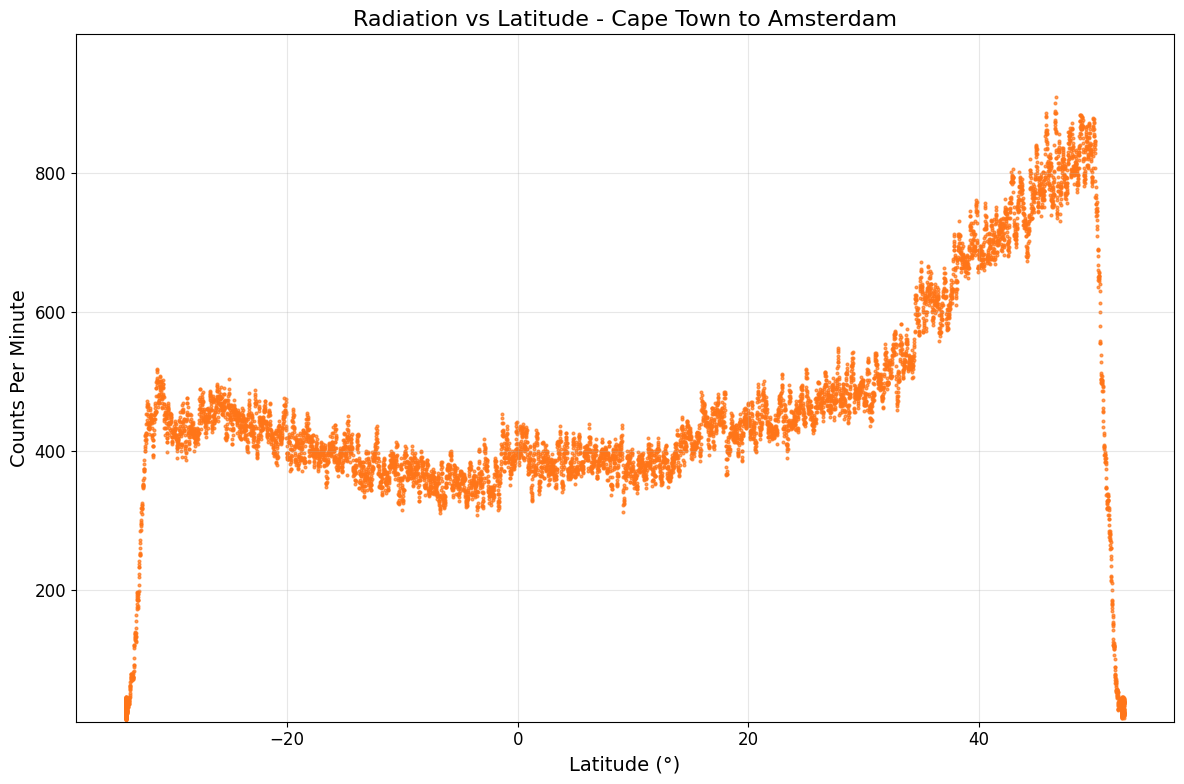

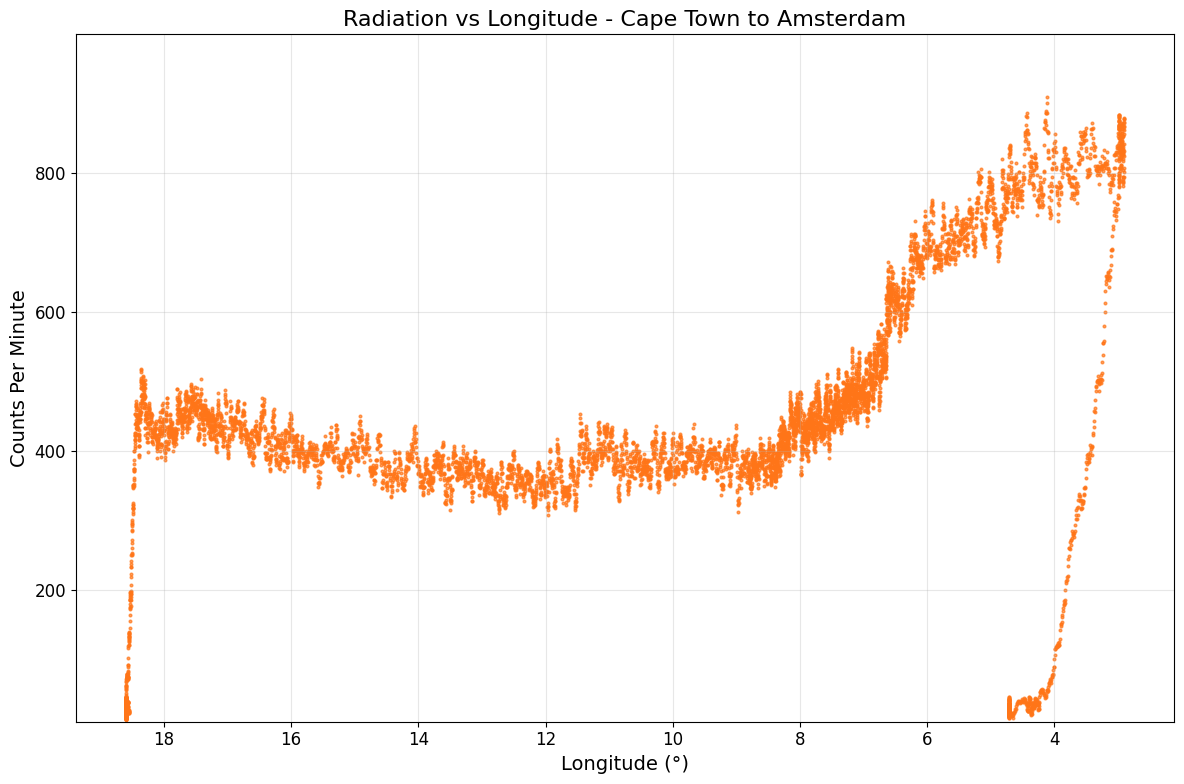

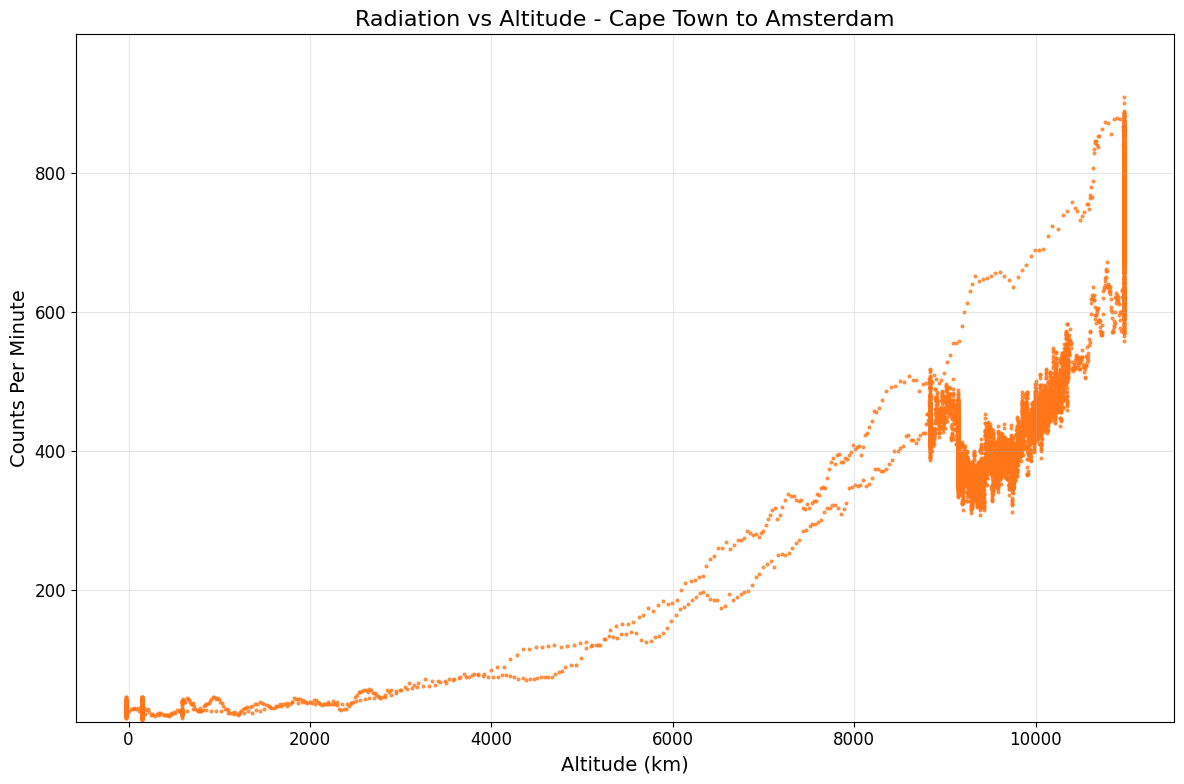

In [32]:
def plot_radiation_vs_position(data, coordinates, coord_type, flight_info):
    """
    Plot radiation levels vs geographic coordinates (lat, lon, or altitude).
    
    Args:
        data: List of data records
        coordinates: List of coordinate values (lat, lon, or alt)
        coord_type: 'latitude', 'longitude', or 'altitude'
        flight_info: Flight information dictionary
    """
    counts = [d['cpm_1min'] for d in data]
    
    plt.figure(figsize=(12, 8))
    plt.scatter(coordinates, counts, marker='.', color='#FF7518', s=15, alpha=0.7)
    
    # Set labels and title based on coordinate type
    if coord_type == 'latitude':
        plt.xlabel('Latitude (°)', fontsize=14)
        plt.title(f'Radiation vs Latitude - {flight_info["route"]}', fontsize=16)
        
        # Ensure proper orientation (takeoff on left)
        if coordinates[0] > coordinates[-1]:
            plt.gca().invert_xaxis()
            
    elif coord_type == 'longitude':
        plt.xlabel('Longitude (°)', fontsize=14)
        plt.title(f'Radiation vs Longitude - {flight_info["route"]}', fontsize=16)
        if coordinates[0] > coordinates[-1]:
            plt.gca().invert_xaxis()

    elif coord_type == 'altitude':
        plt.xlabel('Altitude (km)', fontsize=14)
        plt.title(f'Radiation vs Altitude - {flight_info["route"]}', fontsize=16)
        coordinates = [alt/1000 for alt in coordinates]  # Convert m to km

    
    plt.ylabel('Counts Per Minute', fontsize=14)
    plt.ylim(10, max(counts)*1.1)
    plt.grid(True, alpha=0.3)
    

    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}radiation_vs_{coord_type}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create spatial analysis plots
if len(data_all) > 0 and 'interp_lats' in locals():
    print("### Spatial Analysis")
    print("These plots reveal how radiation varies with geographic position and altitude.")
    
    # Use interpolated coordinates if available, otherwise use GPS data
    if GPS_AVAILABLE and data_gps:
        use_lats = [d['gps_lat'] for d in data_gps]
        use_lons = [d['gps_lon'] for d in data_gps]  
        use_alts = [d['gps_alt'] for d in data_gps]
        use_data = data_gps
    else:
        use_lats = interp_lats
        use_lons = interp_lons
        use_alts = interp_alts
        use_data = data_all
    
    plot_radiation_vs_position(use_data, use_lats, 'latitude', FLIGHT_INFO)
    plot_radiation_vs_position(use_data, use_lons, 'longitude', FLIGHT_INFO)  
    plot_radiation_vs_position(use_data, use_alts, 'altitude', FLIGHT_INFO)

<font size = 3>

$\textbf{World Map Visualization}$

### World Map Visualization
This map shows the complete flight path with radiation levels color-coded.
Higher radiation (warmer colors) typically occurs at higher altitudes and latitudes.


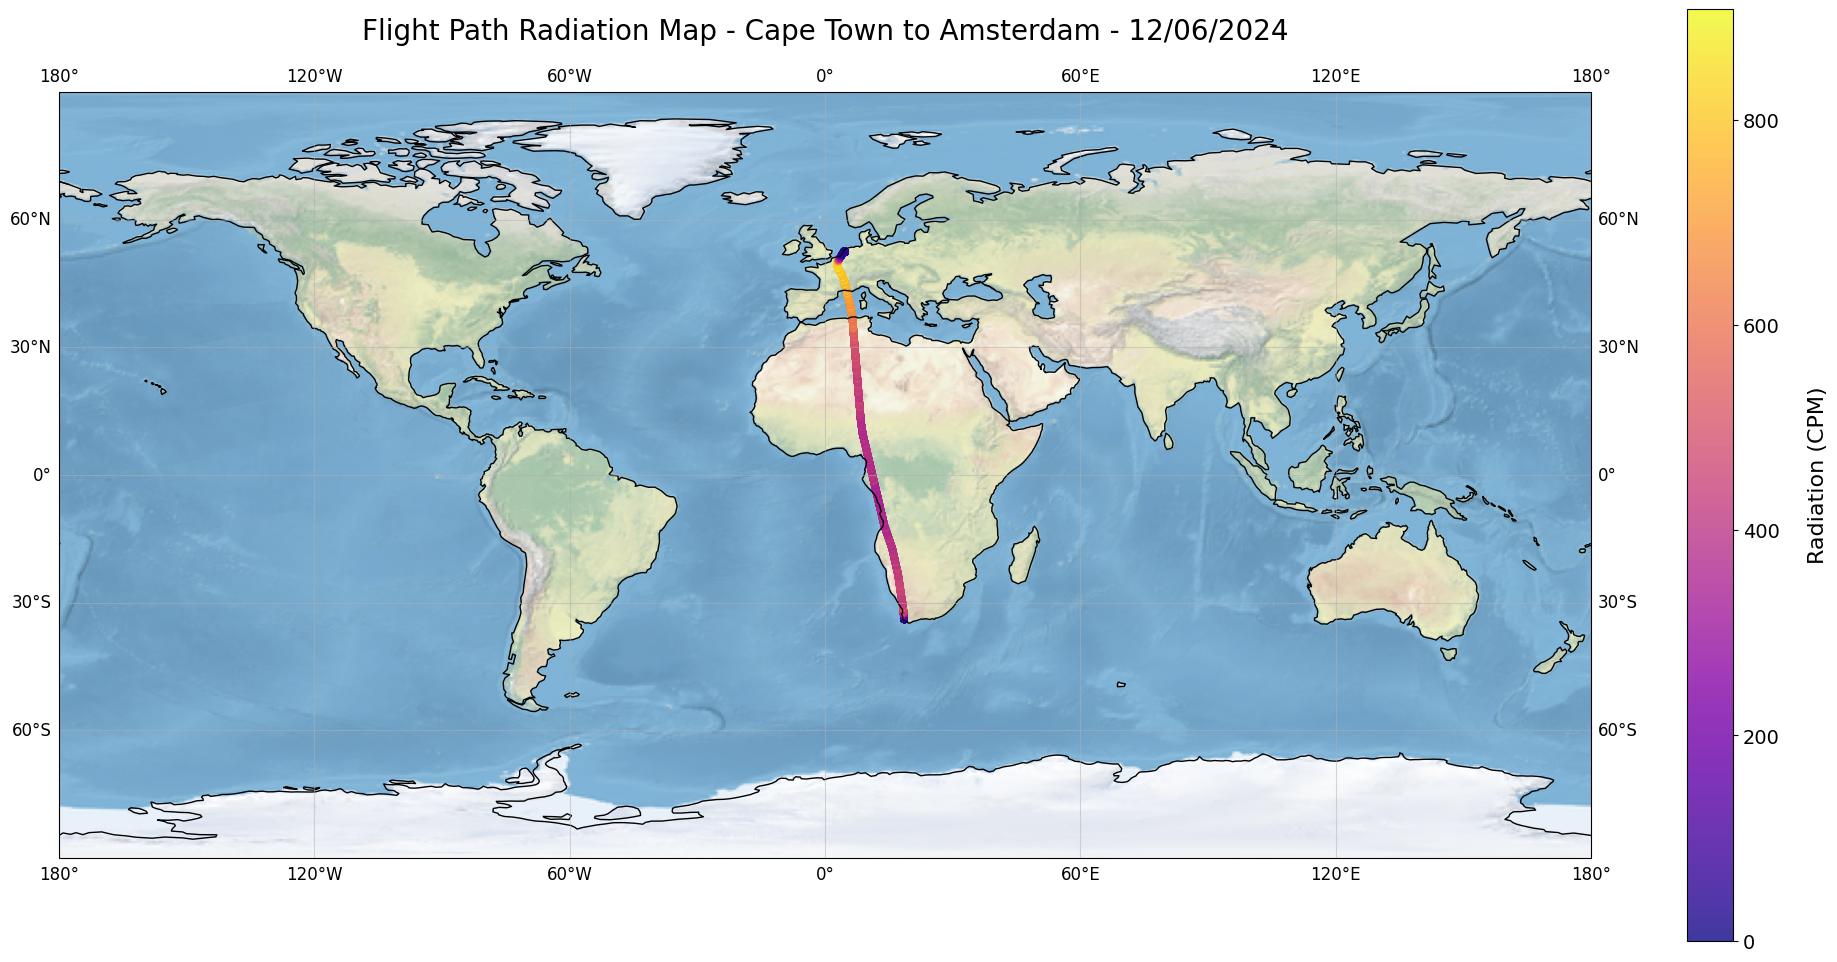

In [33]:
def create_world_map(lons, lats, radiation_data, flight_info):
    """
    Create a world map showing the flight path colored by radiation intensity.
    
    Args:
        lons: List of longitudes
        lats: List of latitudes  
        radiation_data: List of radiation measurements
        flight_info: Flight information dictionary
    """
    # Calculate reasonable color scale limits
    radiation_values = [d['cpm_1min'] for d in radiation_data]
    max_radiation = max(radiation_values)
    
    # Cap extreme values to prevent color scale skewing
    capped_radiation = []
    cap_limit = max_radiation * 0.95
    for val in radiation_values:
        capped_radiation.append(min(val, cap_limit))
    
    # Create the map
    fig = plt.figure(figsize=(20, 12))
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    ax.stock_img()
    
    # Plot flight path with radiation color mapping
    scatter = plt.scatter(lons, lats, c=capped_radiation, cmap='plasma', 
                         s=20, vmin=0, vmax=max_radiation, alpha=0.8)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.8)
    cbar.set_label('Radiation (CPM)', labelpad=20, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    
    # Set map extent and labels
    plt.xlim(-180, 180)
    plt.ylim(-90, 90)
    plt.title(f'Flight Path Radiation Map - {flight_info["route"]} - {flight_info["date"]}', 
              fontsize=20, pad=20)
    
    # Add grid and coastlines for reference
    ax.gridlines(draw_labels=True, alpha=0.5)
    ax.coastlines()
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}world_radiation_map.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create world map if coordinates available
if len(data_all) > 0 and 'interp_lats' in locals():
    print("### World Map Visualization")
    print("This map shows the complete flight path with radiation levels color-coded.")
    print("Higher radiation (warmer colors) typically occurs at higher altitudes and latitudes.")
    
    create_world_map(interp_lons, interp_lats, data_all, FLIGHT_INFO)

### $\textbf{6. CARI-7 Data Conversion}$

<font size = 3>

$\textbf{About CARI-7}$

CARI-7 (Civil Aerospace Medical Institute Radiation) is the FAA's model for predicting cosmic radiation exposure during flight. It considers:
 - Solar activity cycle: 11-year variation in cosmic ray intensity
 - Geomagnetic effects: Earth's magnetic field deflection
 - Atmospheric depth: Altitude-dependent shielding
 - Geographic location: Latitude and longitude effects

In [34]:
def create_cari_input_files(data, coordinates, output_dir, flight_info):
    """
    Generate CARI-7 input files for total and neutron radiation calculations.
    
    Args:
        data: List of measurement records
        coordinates: Dict with 'lats', 'lons', 'alts' coordinate lists  
        output_dir: Directory to save CARI input files
        flight_info: Flight information dictionary
        
    Returns:
        tuple: (total_file_path, neutron_file_path)
    """
    # Generate output filenames
    detector_id = flight_info['detector_id']
    total_filename = f'CARI7_input_total_{detector_id}.LOC'
    neutron_filename = f'CARI7_input_neutron_{detector_id}.LOC'
    
    total_path = Path(output_dir) / total_filename
    neutron_path = Path(output_dir) / neutron_filename
    
    # Prepare coordinate data
    lats = coordinates['lats'] 
    lons = coordinates['lons']
    alts = coordinates['alts']  # in meters
    
    # Format data for CARI-7
    formatted_data = []
    for i, record in enumerate(data):
        # Convert coordinates to CARI format
        lat_val = abs(lats[i])
        lat_deg = int(lat_val)
        lat_min = (lat_val - lat_deg) * 60
        lat_formatted = lat_deg + lat_min/100
        lat_dir = 'N' if lats[i] >= 0 else 'S'
        
        lon_val = abs(lons[i]) 
        lon_deg = int(lon_val)
        lon_min = (lon_val - lon_deg) * 60
        lon_formatted = lon_deg + lon_min/100
        lon_dir = 'E' if lons[i] >= 0 else 'W'
        
        # Convert altitude from meters to feet
        alt_kft = alts[i] * 3.28084 / 1000
        
        # Format date and time
        dt = record['datetime']
        date_str = dt.strftime('%Y/%m/%d')
        hour_str = f'H{dt.hour:02d}'
        
        formatted_record = {
            'lat_dir': lat_dir,
            'lat': lat_formatted,
            'lon_dir': lon_dir, 
            'lon': lon_formatted,
            'alt': alt_kft,
            'date': date_str,
            'time': hour_str
        }
        formatted_data.append(formatted_record)
    
    # Write total radiation file (P0 parameter)
    with open(total_path, 'w') as f:
        f.write("START-------------------------------------------------\n")
        for record in formatted_data:
            line = f"{record['lat_dir']},{record['lat']:.2f},{record['lon_dir']},{record['lon']:.2f},K,{record['alt']:.2f},{record['date']},{record['time']},D4,P0,C4,S0\n"
            f.write(line)
        f.write("STOP-------------------------------------------------\n")
    
    # Write neutron radiation file (P1 parameter)  
    with open(neutron_path, 'w') as f:
        f.write("START-------------------------------------------------\n")
        for record in formatted_data:
            line = f"{record['lat_dir']},{record['lat']:.2f},{record['lon_dir']},{record['lon']:.2f},K,{record['alt']:.2f},{record['date']},{record['time']},D4,P1,C4,S0\n"
            f.write(line)
        f.write("STOP-------------------------------------------------\n")
    
    print(f"CARI-7 input files created:")
    print(f"  Total radiation: {total_filename}")
    print(f"  Neutron radiation: {neutron_filename}")
    print(f"  Records processed: {len(formatted_data)}")
    
    return str(total_path), str(neutron_path)

# Generate CARI-7 input files
if len(data_all) > 0 and 'interp_lats' in locals():
    print("### CARI-7 Input File Generation")
    print("These files can be processed in the CARI-7 application to calculate radiation exposure.")
    print("https://www.faa.gov/data_research/research/med_humanfacs/aeromedical/radiobiology/cari7/")
    
    coordinates_dict = {
        'lats': interp_lats,
        'lons': interp_lons, 
        'alts': interp_alts
    }
    
    total_file, neutron_file = create_cari_input_files(
        data_all, coordinates_dict, OUTPUT_DIR, FLIGHT_INFO
    )


### CARI-7 Input File Generation
These files can be uploaded to the CARI-7 online calculator:
https://www.faa.gov/data_research/research/med_humanfacs/aeromedical/radiobiology/cari7/
CARI-7 input files created:
  Total radiation: CARI7_input_total_3289.LOC
  Neutron radiation: CARI7_input_neutron_3289.LOC
  Records processed: 9502


In [35]:
def create_cari_input_files(data, coordinates, output_dir, flight_info):
    """
    Generate CARI-7 input files for total and neutron radiation calculations.
    
    Args:
        data: List of measurement records
        coordinates: Dict with 'lats', 'lons', 'alts' coordinate lists  
        output_dir: Directory to save CARI input files
        flight_info: Flight information dictionary
        
    Returns:
        tuple: (total_file_path, neutron_file_path)
    """
    # Generate output filenames
    detector_id = flight_info['detector_id']
    total_filename = f'CARI7 output_total_{detector_id}.LOC'
    neutron_filename = f'CARI7 output_neutrons_{detector_id}.LOC'
    
    total_path = Path(output_dir) / total_filename
    neutron_path = Path(output_dir) / neutron_filename
    
    # Prepare coordinate data
    lats = coordinates['lats']
    lons = coordinates['lons']
    alts = coordinates['alts']  # in meters
    
    # Format data for CARI-7
    formatted_data = []
    for i, record in enumerate(data):
        try:
            # Convert latitude to CARI format
            lat_val = abs(lats[i])
            lat_deg = int(lat_val)
            lat_min = (lat_val - lat_deg) * 60
            lat_formatted = lat_deg + lat_min/100
            lat_dir = 'N' if lats[i] >= 0 else 'S'
            
            # Convert longitude to CARI format
            lon_val = abs(lons[i])
            lon_deg = int(lon_val)
            lon_min = (lon_val - lon_deg) * 60
            lon_formatted = lon_deg + lon_min/100
            lon_dir = 'E' if lons[i] >= 0 else 'W'
            
            # Convert altitude from meters to kilofeet
            alt_kft = alts[i] * 3.28084 / 1000  # meters to kilofeet
            
            # Format date and time
            dt = record['datetime']
            date_str = dt.strftime('%Y/%m/%d')
            hour_str = f'H{dt.hour:02d}'
            
            formatted_record = {
                'lat_dir': lat_dir,
                'lat': lat_formatted,
                'lon_dir': lon_dir,
                'lon': lon_formatted,
                'alt': alt_kft,
                'date': date_str,
                'time': hour_str
            }
            formatted_data.append(formatted_record)
            
        except (ValueError, IndexError) as e:
            print(f"Warning: Error formatting record {i}: {e}")
            continue
    
    # Write total radiation file (P0 parameter)
    with open(total_path, 'w') as f:
        f.write("START-------------------------------------------------\n")
        for record in formatted_data:
            line = f"{record['lat_dir']}, {record['lat']:.2f}, {record['lon_dir']}, {record['lon']:.2f}, K, {record['alt']:.2f}, {record['date']}, {record['time']}, D4, P0, C4, S0\n"
            f.write(line)
        f.write("STOP-------------------------------------------------\n")
    
    # Write neutron radiation file (P1 parameter)
    with open(neutron_path, 'w') as f:
        f.write("START-------------------------------------------------\n")
        for record in formatted_data:
            line = f"{record['lat_dir']}, {record['lat']:.2f}, {record['lon_dir']}, {record['lon']:.2f}, K, {record['alt']:.2f}, {record['date']}, {record['time']}, D4, P1, C4, S0\n"
            f.write(line)
        f.write("STOP-------------------------------------------------\n")
    
    print(f"CARI-7 input files created:")
    print(f"  Total radiation: {total_filename}")
    print(f"  Neutron radiation: {neutron_filename}")
    print(f"  Records processed: {len(formatted_data)}")
    
    return str(total_path), str(neutron_path)

### $\textbf{7. Model Comparison}$

<font size = 3>

$\textbf{Loading CARI-7 Results}$

After running your data through CARI-7, you'll receive .ANS files with predicted dose rates. This section compares measurements with model predictions.

$\textbf{Understanding Model Differences}$

Differencees between measured and predicted radiation can occur due to:
- Solar cycle variations: CARI-7 uses historical averages
- Detector sensitivity: Individual detector calibration differences
- Local magnetic field effects: Real-time variations not captured in models
- Atmospheric conditions: Weather effects on cosmic ray propagation

In [ ]:
def load_cari_results(total_file, neutron_file):
    """Load CARI-7 output files and extract predicted dose rates."""
    cari_data = {
        'total_doses': [],
        'neutron_doses': [],
        'altitudes': [],
        'non_neutron_doses': [],
        'times': [],
        'latitudes': [],
        'longitudes': []
    }
    
    # Initialize time-related variables
    base_date = datetime.datetime(2024, 6, 12)  # Year, Month, Day
    current_date = base_date
    previous_hour = 0
    
    # Load total radiation results
    try:
        with open(total_file, 'r') as f:
            next(f)  # Skip header
            for line in f:
                columns = line.strip().split(',')
                if len(columns) >= 9:
                    # Extract data from columns
                    dose_rate = float(columns[8])  # μSv/h
                    altitude_ft = float(columns[2])  # feet
                    altitude_km = altitude_ft / 3280.8399  # convert to km
                    latitude = float(columns[0])  # Latitude in degrees
                    longitude = columns[1] # Longitude in degrees
                    
                    # Parse and convert time with day rollover
                    cari_tot_timestamp = float(columns[5])
                    current_hour = float(cari_tot_timestamp)
                    
                    # Handle day rollover at midnight
                    if current_hour < previous_hour:
                        current_date += timedelta(days=1)
                    timestamp = current_date + timedelta(hours=current_hour)
                    previous_hour = current_hour
                    
                    # Store all data
                    cari_data['total_doses'].append(dose_rate)
                    cari_data['altitudes'].append(altitude_km)
                    cari_data['latitudes'].append(latitude)
                    cari_data['longitudes'].append(longitude)
                    cari_data['times'].append(timestamp)
        
        print(f"\nCARI-7 Data Loading Summary:")
        print(f"Loaded {len(cari_data['total_doses'])} CARI-7 total dose predictions")

        if cari_data['times']:
            print(f"Time range: {cari_data['times'][0]} to {cari_data['times'][-1]}")
            print("\nFirst 5 timestamps:")
            for t in cari_data['times'][:5]:
                print(f"  {t.strftime('%Y-%m-%d %H:%M')}")
                
    except FileNotFoundError:
        print(f"CARI-7 total file not found: {total_file}")
        print("Note: You need to run your .LOC files through CARI-7 first!")
    
    # Load neutron radiation results (unchanged)
    try:
        with open(neutron_file, 'r') as f:
            next(f)  # Skip header
            for line in f:
                columns = line.strip().split(',')
                if len(columns) >= 9:
                    neutron_dose = float(columns[8])  # μSv/h
                    cari_data['neutron_doses'].append(neutron_dose)
        
        print(f"Loaded {len(cari_data['neutron_doses'])} CARI-7 neutron dose predictions")
    except FileNotFoundError:
        print(f"CARI-7 neutron file not found: {neutron_file}")
    
    # Calculate non-neutron component (total - neutron)
    if len(cari_data['total_doses']) == len(cari_data['neutron_doses']):
        cari_data['non_neutron_doses'] = [
            total - neutron for total, neutron 
            in zip(cari_data['total_doses'], cari_data['neutron_doses'])
        ]
        print("Calculated non-neutron dose component")
    
    return cari_data


### CARI-7 Model Comparison
This section compares measured radiation with CARI-7 model predictions.
Note: You need to process the .LOC files through CARI-7 first!

CARI-7 Data Loading Summary:
Loaded 9174 CARI-7 total dose predictions
Time range: 2024-06-12 21:00:00 to 2024-06-13 10:00:00

First 5 timestamps:
  2024-06-12 21:00
  2024-06-12 21:00
  2024-06-12 21:00
  2024-06-12 21:00
  2024-06-12 21:00
Loaded 9174 CARI-7 neutron dose predictions
Calculated non-neutron dose component


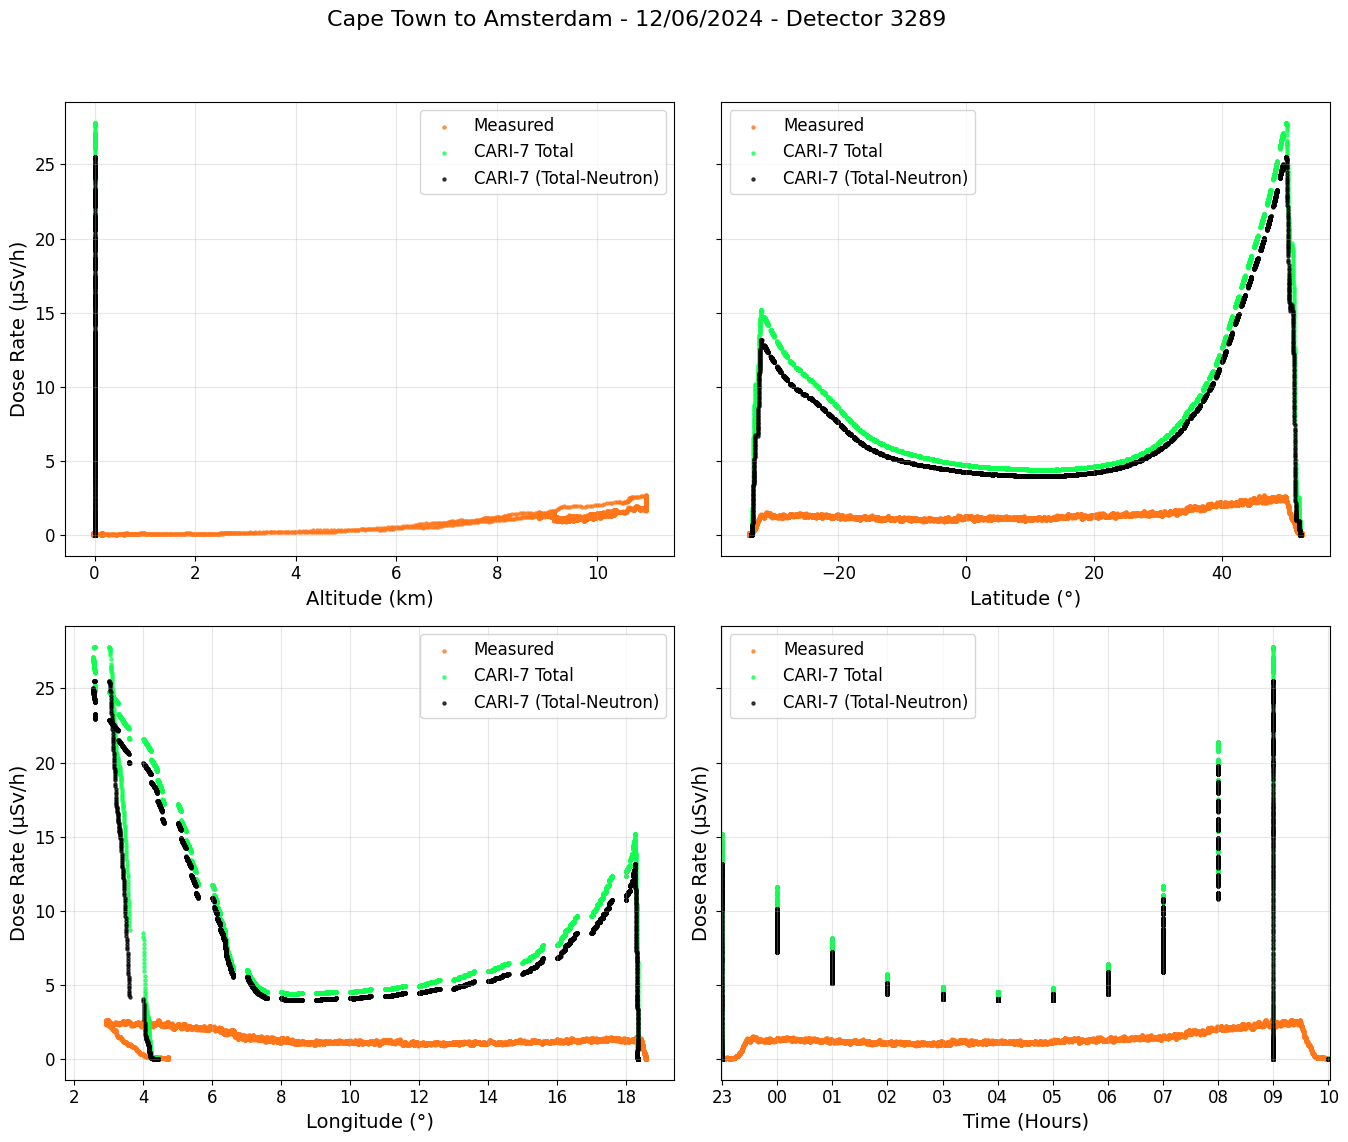

In [48]:

def compare_measured_vs_predicted(measured_data, coordinates_dict, cari_data, flight_info):
    """
    Create comprehensive comparison plots between measured and CARI-7 predicted doses.
    
    Args:
        measured_data: List of measurement records
        cari_data: Dictionary with CARI-7 predictions
        flight_info: Flight information dictionary
        data_all: List of all data records with GPS coordinates
    """
    # Convert measured data to dose rates
    measured_doses = [record['cpm_1min'] / CONVERSION_FACTOR for record in measured_data]
    measured_altitudes = [alt/1000 for alt in coordinates_dict['alts']]  # km
    measured_latitude = coordinates_dict['lats']
    measured_longitude = coordinates_dict['lons']
    measured_times = [record['datetime'] for record in measured_data]

    # Converting the CARI-7 GPS data to floats
    cari_data['longitudes'] = [float(lon) for lon in cari_data['longitudes']]


    # Ensure consistent longitude plotting direction
    # Check if we need to reverse the measured longitudes
    if measured_longitude[0] < measured_longitude[-1]:
        measured_longitude = list(reversed(measured_longitude))
        measured_doses = list(reversed(measured_doses))

    # Check of we need to reverse CARI-7 data
    if cari_data['longitudes'] and cari_data['longitudes'][0] < cari_data['longitudes'][-1]:
        cari_data['longitudes'] = list(reversed(cari_data['longitudes']))
        cari_data['total_doses'] = list(reversed(cari_data['total_doses']))
        if cari_data['non_neutron_doses']:
            cari_data['non_neutron_doses'] = list(reversed(cari_data['non_neutron_doses']))    

    # Create subplots for comparison
    fig, axs = plt.subplots(2 ,2, figsize=(15, 12), sharey = True)
    fig.suptitle('Cape Town to Amsterdam - 12/06/2024 - Detector 3289', fontsize=16)


##############################################################################################################################


    # Plot 1: Dose rate vs altitude
    axs[0, 0].scatter(measured_altitudes, measured_doses, 
                      marker='.', color='#FF7518', s=20, alpha=0.7, label='Measured')
    axs[0, 0].set_xlabel('Altitude (km)', fontsize=14)
    axs[0, 0].set_ylabel('Dose Rate (μSv/h)', fontsize=14)
    # axs[0, 0].set_title(f'Measured Dose Rates - {flight_info["route"]}', fontsize=16)
    axs[0, 0].grid(True, alpha=0.3)
    

    if cari_data['total_doses']:
        axs[0, 0].scatter(cari_data['altitudes'], cari_data['total_doses'],
                   marker='.', color='#0FFF50', s=20, alpha=0.7, label='CARI-7 Total')
        
    if cari_data['non_neutron_doses']:
        axs[0, 0].scatter(cari_data['altitudes'], cari_data['non_neutron_doses'],
                   marker='.', color='black', s=20, alpha=0.7, label='CARI-7 (Total-Neutron)')
    axs[0, 0].legend()    

##############################################################################################################################

    # Plot 2: Dose rate vs latitude
    axs[0, 1].scatter(measured_latitude, measured_doses,
                  marker='.', color='#FF7518', s=20, alpha=0.7, label='Measured')
    axs[0, 1].set_xlabel('Latitude (°)', fontsize=14)
    #axs[0, 1].set_title(f'Measured Dose Rates vs Latitude - {flight_info["route"]}', fontsize=16)
    axs[0, 1].grid(True, alpha=0.3)

    if cari_data['total_doses']:
        axs[0, 1].scatter(cari_data['latitudes'], cari_data['total_doses'],
                   marker='.', color='#0FFF50', s=20, alpha=0.7, label='CARI-7 Total')
    if cari_data['non_neutron_doses']:
        axs[0, 1].scatter(cari_data['latitudes'], cari_data['non_neutron_doses'],
                   marker='.', color='black', s=20, alpha=0.7, label='CARI-7 (Total-Neutron)')
    axs[0, 1].legend()



##############################################################################################################################
    
    # Plot 3: Dose rate vs longitude
    axs[1, 0].scatter(measured_longitude, measured_doses,
                      marker='.', color='#FF7518', s=20, alpha=0.7, label='Measured')
    axs[1, 0].set_xlabel('Longitude (°)', fontsize=14)
    axs[1, 0].set_ylabel('Dose Rate (μSv/h)', fontsize=14)
    #axs[1, 0].set_title(f'Measured Dose Rates vs Longitude - {flight_info["route"]}', fontsize=16)
    axs[1, 0].grid(True, alpha=0.3)

    if cari_data['total_doses']:
        axs[1, 0].scatter(cari_data['longitudes'], cari_data['total_doses'],
                   marker='.', color='#0FFF50', s=20, alpha=0.7, label='CARI-7 Total')
    if cari_data['non_neutron_doses']:
        axs[1, 0].scatter(cari_data['longitudes'], cari_data['non_neutron_doses'],
                   marker='.', color='black', s=20, alpha=0.7, label='CARI-7 (Total-Neutron)')
    
    axs[1, 0].legend()

##############################################################################################################################
    # Plot 4: Dose rate vs time
    axs[1, 1].scatter(measured_times, measured_doses,
                      marker='.', color='#FF7518', s=20, alpha=0.7, label='Measured')
    if cari_data['total_doses'] and cari_data['times']:
        
        axs[1, 1].scatter(cari_data['times'], cari_data['total_doses'],
                         marker='.', color='#0FFF50', s=20, alpha=0.7, label='CARI-7 Total')
        
    if cari_data['non_neutron_doses']:
        axs[1, 1].scatter(cari_data['times'], cari_data['non_neutron_doses'],
                         marker='.', color='black', s=20, alpha=0.7, label='CARI-7 (Total-Neutron)')
    
    # Find relevant time boundaries with baseline padding
    start_index = 0
    for i in range(1, len(measured_doses)):
        if abs(measured_doses[i] - measured_doses[0]) > 0.1:

            # Include some baseline data by moving back a few points
            start_index = max(0, i - 200)  # Show ~200 data points of baseline
            break

    end_index = len(measured_doses) - 1
    for i in range(len(measured_doses) - 2, 0, -1):
        if abs(measured_doses[i] - measured_doses[-1]) > 0.1:

            # Include some baseline data at the end
            end_index = min(len(measured_doses) - 1, i + 200)
            break

    # Set axis limits to focus on flight data with baseline padding
    axs[1, 1].set_xlim(measured_times[start_index], measured_times[end_index])
   
    
    # Format time axis
    axs[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    axs[1, 1].xaxis.set_major_locator(mdates.HourLocator(interval=1))
    
    # Other formatting
    axs[1, 1].set_xlabel('Time (Hours)', fontsize=14)
    axs[1, 1].set_ylabel('Dose Rate (μSv/h)', fontsize=14)
    axs[1, 1].grid(True, alpha=0.3)
    axs[1, 1].legend()

    # Adjust layout
    #axs[1, 1].set_title(f'Measured Dose Rates vs Longitude - {flight_info["route"]}', fontsize=16)
    plt.tight_layout(rect=[0.07, 0.03, 0.98, 0.95])  # [left, bottom, right, top]


# Update these paths to your CARI-7 output files that you obtained from the CARI-7 FAA software
CARI_TOTAL_OUTPUT = 'C:\\Users\\Tadeck\\.CodingBrav\\Cosmic On Air\\Example Data Sets\\Cape Town to Amsterdam ( Flight KLM598 - 12_06_2024)\\Analysis_Output\\CARI7_input_total_3289.ANS'
CARI_NEUTRON_OUTPUT = 'C:\\Users\\Tadeck\\.CodingBrav\\Cosmic On Air\\Example Data Sets\\Cape Town to Amsterdam ( Flight KLM598 - 12_06_2024)\\Analysis_Output\\CARI7_input_neutron_3289.ANS'

if len(data_all) > 0:
    print("### CARI-7 Model Comparison")
    print("This section compares measured radiation with CARI-7 model predictions.")
    print("Note: You need to process the .LOC files through CARI-7 first!")
    
    # Load CARI-7 results
    cari_results = load_cari_results(CARI_TOTAL_OUTPUT, CARI_NEUTRON_OUTPUT)
        
    # Create comparison plots
    compare_measured_vs_predicted(data_all, coordinates_dict, cari_results, FLIGHT_INFO)



### 